This notebook has been tested with python 3.9.12. The libraries have also been tested with python 3.10.

In [1]:
%pylab inline
import pandas as pd
import libaarhusxyz
import numpy as np
import SimPEG.electromagnetics.utils.static_instrument.dual

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Cannot import Pardiso, will use SolverLU
No MKL support:  No module named 'pyMKL'
Could not import PardisoSolver, only default (spLU) available


# Data preparation

Download data from https://purl.stanford.edu/vj301kx0276 and place it in the folder data/IncisedValley.

As this data is not in the original SkyTEM XYZ format, but has been converted to a CSV (the header has been stripped) we need to convert it back to that format.

In [2]:
x = libaarhusxyz.XYZ()
x.flightlines = pd.read_csv("data/IncisedValley/aem_processed_data_foothill_central_valley.csv")
x.model_info["scalefactor"] = 1 # Unit in file is V/(Am**4), if data is in picoV, set to 1e-12 :)
# Our code expects tild to be measured as degrees from vertical of the transmitter loop normal.
# Input data is referenced to positive x, so we need to rotate it...
x.flightlines.TILT_X -= 270
x.flightlines.TILT_Y -= 270

x.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.xyz")

Extract a single flightlines so that the inversion in this example notebook doesn't take forever to run :)

In [3]:
x = libaarhusxyz.XYZ("data/IncisedValley/aem_processed_data_foothill_central_valley.xyz", normalize=True)
filt = x.flightlines.title == 302701.0
x.flightlines = x.flightlines.loc[filt].reset_index(drop=True)
for key, value in x.layer_data.items():
    x.layer_data[key] = value.loc[filt].reset_index(drop=True)

x.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz")

# Inversion

Load the data int RAM, prepare a calibrated system description, invert the data and plot the result.

In [2]:
measured = libaarhusxyz.XYZ("data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz", normalize=True)
gex = libaarhusxyz.GEX("data/IncisedValley/aem_processed_data_foothill_central_valley.gex")

header [General] parsed
header [Channel1] parsed
header [Channel2] parsed


In [3]:
measured.layer_data.keys()

dict_keys(['dbdt_ch1gt', 'dbdt_ch2gt', 'dbdt_std_ch1gt', 'dbdt_std_ch2gt'])

In [4]:
measured.layer_data["dbdt_inuse_ch1gt"] = measured.layer_data["dbdt_ch1gt"] * 0 + 1
measured.layer_data["dbdt_inuse_ch2gt"] = measured.layer_data["dbdt_ch2gt"] * 0 + 1

In [5]:
measured.flightlines = measured.flightlines.iloc[:10]
for key in measured.layer_data.keys():
    measured.layer_data[key] = measured.layer_data[key].iloc[:10]
    

## Data plotting
Note that this is unprocessed and pretty noisy data

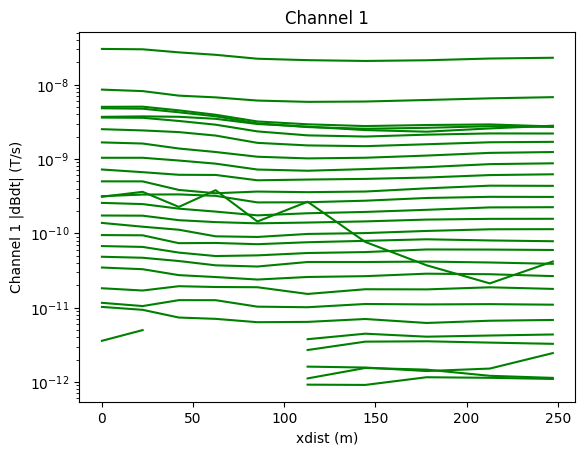

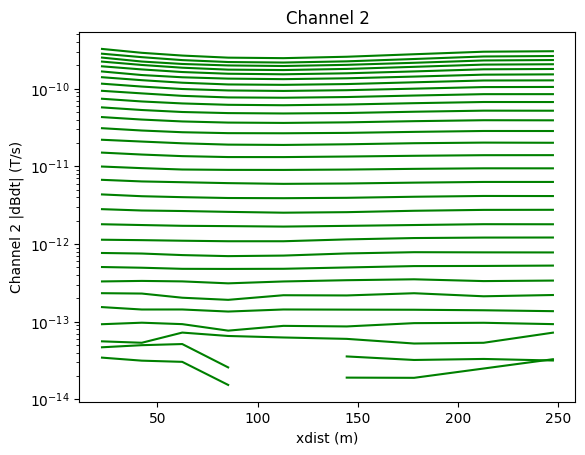

In [6]:
for channel in (1, 2):
    measured.plot_line(302701.0, channel=channel, ax=plt.gca(), color="green", label="Measured")
    plt.title("Channel %s" % channel)
    plt.show()

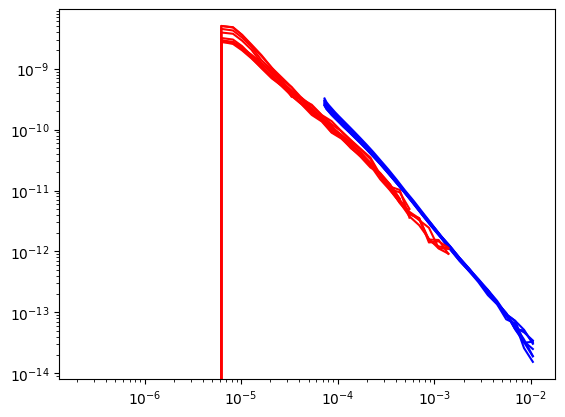

In [7]:
for row in range(0, len(measured.flightlines)):
    plt.loglog(gex.gate_times('Channel2')[:,0], measured.layer_data["dbdt_ch2gt"].iloc[row], color="blue")
    plt.loglog(gex.gate_times('Channel1')[:,0], measured.layer_data["dbdt_ch1gt"].iloc[row], color="red")
plt.show()

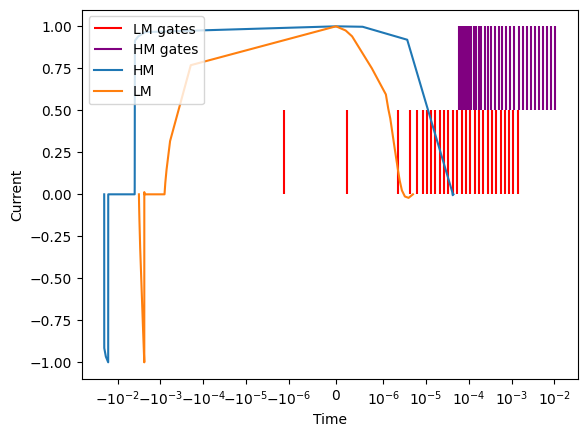

In [8]:
gex.plot()

## Set up the iversion

We first create a calibrated system description using the GEX file. We then instantiate this system with the data.
As noted, the data is pretty noisy, so we filter out quite a few gates. In a real project, this would be done more
carefully and gates would be culled per sounding using the InUse flag columns of the xyz.

The CalibratedSystem embodies a full description of the instrument as it stands on the ground, detailed enough to be able to invert data measured by it.

In [9]:
CalibratedSystem = SimPEG.electromagnetics.utils.static_instrument.dual.DualMomentTEMXYZSystem.load_gex(gex)

Combine the CalibratedSystem and some measured data. Here we also filter out some of the fates of the data as they are too noisy. Note: This does not perform the inversion, it only sets up all objects needed to perform it.

In [10]:
# Check number of gates
len(measured.layer_data["dbdt_ch1gt"].columns), len(measured.layer_data["dbdt_ch2gt"].columns)

(28, 37)

In [11]:
inv = CalibratedSystem(
    measured,
    gate_filter__start_lm=7,
    gate_filter__end_lm=21,
    gate_filter__start_hm=15,
    gate_filter__end_hm=30,
    simulation__parallel = False,
    simulation__n_cpu = 1
)

## Sanity check plotting

Plot the filtered data, as it will go into the inversion

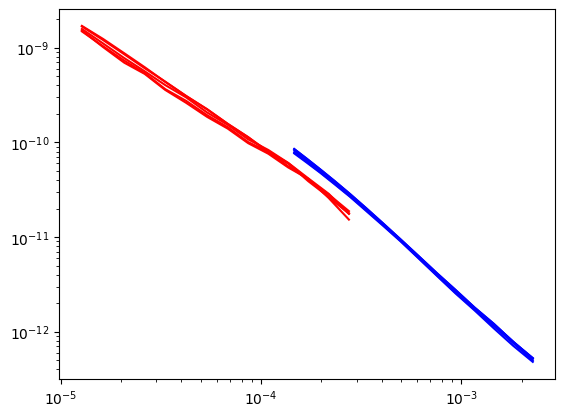

In [12]:
for row in range(0, len(inv.xyz.flightlines)):
    plt.loglog(inv.times[1], inv.xyz.layer_data["dbdt_ch2gt"].iloc[row], color="blue")
    plt.loglog(inv.times[0], inv.xyz.layer_data["dbdt_ch1gt"].iloc[row], color="red")
plt.show()

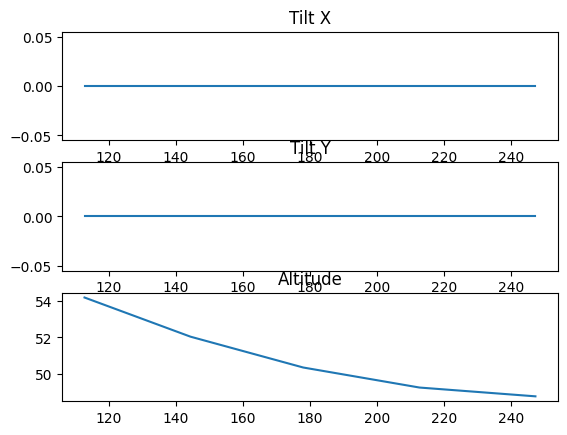

In [13]:
fig = plt.figure()
axs = fig.subplots(3, 1).flatten()

axs[0].set_title("Tilt X")
axs[0].plot(inv.xyz.flightlines.xdist, inv.xyz.flightlines.tilt_x)
axs[1].set_title("Tilt Y")
axs[1].plot(inv.xyz.flightlines.xdist, inv.xyz.flightlines.tilt_y)
axs[2].set_title("Altitude")
axs[2].plot(inv.xyz.flightlines.xdist, inv.xyz.flightlines.tx_altitude)

## Invert the data

In [14]:
import sys
sys.sims_new = []
sys.sims_old = []
sys.use_old = True

In [15]:
inv.invert()

Using default (spLU) solver
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.56e+00  6.77e+03  0.00e+00  6.77e+03    6.25e+02      0              

                Default solver: SolverDiag is being used in bfgsH0
                
   1  1.28e+00  1.38e+03  5.14e+01  1.44e+03    5.00e+02      0              
   2  6.40e-01  6.30e+02  8.84e+01  6.87e+02    7.57e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 6.7685e+02
1 : |xc-x_last| = 1.7575e+00 <= tolX*(1+|x0|) = 5.7402e+00
0 : |proj(x-g)-x|    = 7.5738e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.5738e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      40    <= iter          =      3
------------------------

/home/redhog/Projects/Emerald/em1d/external/simpeg/SimPEG/electromagnetics/utils/static_instrument/base.py:526: RuntimeWarning: invalid value encountered in divide
  xyzresp.flightlines['resdata'] = np.sqrt(np.nansum(derrall**2, axis=1) / (derrall > 0).sum(axis=1))


(None,
 data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz
 --------------------------------
                                                                  0
 scalefactor                                                    1.0
 inversion_type                                                None
 naming_standard                                       libaarhusxyz
 projection                                                    None
 source           data/IncisedValley/aem_processed_data_foothill...
 
 Soundings: 10
 Columns: 18
 Flightlines: 1
 Maximum layer depth: 400.01000000000005
 Projection: None
             x          y
 min  279877.4  4060190.7
 max  280045.7  4060348.5
        Resistivity
 count   150.000000
 mean     21.475021
 std      24.571183
 min       0.618092
 25%       0.647048
 50%       7.240995
 75%      50.488806
 max      68.819077
 
 Layer data: resistivity
 Layer params: layer, dep_top, dep_bot)

In [16]:
sys.use_old = False

In [17]:
inv.invert()

Using default (spLU) solver


/home/redhog/Projects/Emerald/em1d/src/em1d/experiment/experiment.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(overall_min)
/home/redhog/Projects/Emerald/em1d/src/em1d/forwards/forwards.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dz = torch.tensor(self.receiver.z+self.source.z[0], device=self.device)
/home/redhog/Projects/Emerald/em1d/src/em1d/forwards/forwards.py:170: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of 

model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.77e+00  3.07e+04  0.00e+00  3.07e+04    1.71e+03      0              

                Default solver: SolverDiag is being used in bfgsH0
                
   1  1.39e+00  1.93e+04  4.05e+02  1.99e+04    2.45e+02      0              
------------------------------------------------------------------
0 :    ft     = 1.9946e+04 <= alp*descent     = 1.9890e+04
1 : maxIterLS =      10    <= iterLS          =     10
------------------------- End Linesearch -------------------------
The linesearch got broken. Boo.


/home/redhog/Projects/Emerald/em1d/external/simpeg/SimPEG/electromagnetics/utils/static_instrument/base.py:526: RuntimeWarning: invalid value encountered in divide
  xyzresp.flightlines['resdata'] = np.sqrt(np.nansum(derrall**2, axis=1) / (derrall > 0).sum(axis=1))


(None,
 data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz
 --------------------------------
                                                                  0
 scalefactor                                                    1.0
 inversion_type                                                None
 naming_standard                                       libaarhusxyz
 projection                                                    None
 source           data/IncisedValley/aem_processed_data_foothill...
 
 Soundings: 10
 Columns: 18
 Flightlines: 1
 Maximum layer depth: 400.01000000000005
 Projection: None
             x          y
 min  279877.4  4060190.7
 max  280045.7  4060348.5
         Resistivity
 count    150.000000
 mean    2052.153015
 std     4094.978508
 min        0.088781
 25%       10.325554
 50%       25.161433
 75%      747.762158
 max    18376.381046
 
 Layer data: resistivity
 Layer params: layer, dep_top, dep_bot)

In [18]:
def mangleargs(args):
    res = {}
    (
    res["source_list"],
    res["topo"],
    res["thicknesses"],
    res["sigma"],
    res["eta"],
    res["tau"],
    res["c"],
    res["chi"],
    res["dchi"],
    res["tau1"],
    res["tau2"],
    res["h"],
    res["output_type"],
    res["invert_height"],
    res["return_projection"],
    res["coefficients"]
    ) = args
    return res


In [19]:
sims_old = [(mangleargs(item[0]),) + item[1:] for item in sys.sims_old]
sims_new = [(mangleargs(item[0]),) + item[1:] for item in sys.sims_new]

In [20]:
to = [s for s in sims_old if not s[0]["return_projection"] and s[0]["output_type"] != 'forward']

In [21]:
tn = [s for s in sims_new if not s[0]["return_projection"] and s[0]["output_type"] != 'forward']

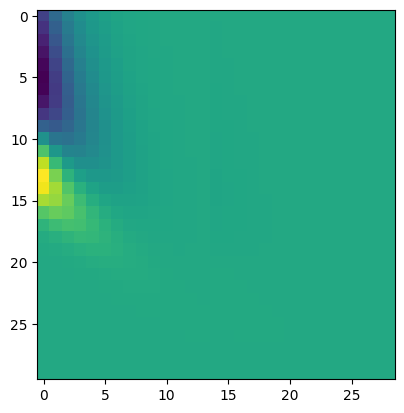

In [22]:
plt.imshow(to[0][1].reshape((30, 29)))

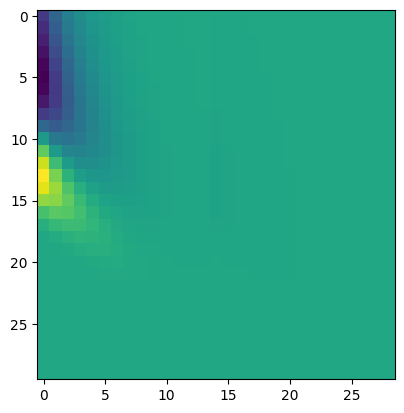

In [23]:
plt.imshow(tn[0][1].reshape((30, 29)))

In [24]:
fo = [s for s in sims_old if not s[0]["return_projection"] and s[0]["output_type"] == 'forward']
fn = [s for s in sims_new if not s[0]["return_projection"] and s[0]["output_type"] == 'forward']

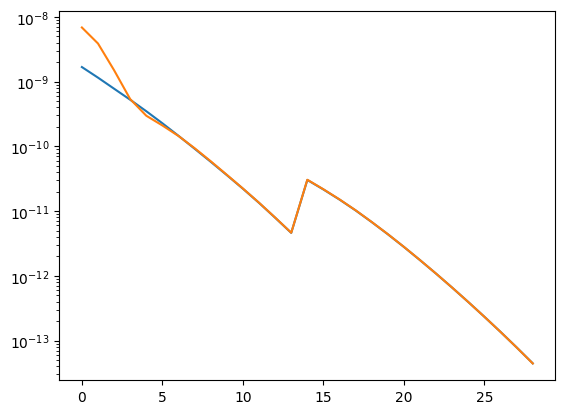

In [26]:
plt.semilogy(np.abs(fo[0][1]))
plt.semilogy(np.abs(fn[0][1]))


tensor([6.8436e-09, 3.8722e-09, 1.4964e-09, 5.3600e-10, 2.9667e-10, 2.0978e-10,
        1.4431e-10, 9.3528e-11, 5.8799e-11, 3.6315e-11, 2.2282e-11, 1.3458e-11,
        7.9410e-12, 4.6250e-12, 3.0464e-11, 2.1688e-11, 1.5121e-11, 1.0272e-11,
        6.7781e-12, 4.3957e-12, 2.7960e-12, 1.7470e-12, 1.0781e-12, 6.5508e-13,
        3.9276e-13, 2.3236e-13, 1.3576e-13, 7.8106e-14, 4.4269e-14],
       dtype=torch.float64)

Actually run the inversion. Note: This takes some 10 minutes on my machine :)

In [11]:
try:
    inv.invert()
except:
    import sys,pdb
    sys.last_traceback = sys.exc_info()[2]
    pdb.pm()

Using default (spLU) solver


/home/redhog/Projects/Emerald/em1d/src/em1d/experiment/experiment.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(overall_min)
/home/redhog/Projects/Emerald/em1d/src/em1d/forwards/forwards.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dz = torch.tensor(self.receiver.z+self.source.z[0], device=self.device)


> /home/redhog/Projects/Emerald/em1d/external/simpeg/SimPEG/electromagnetics/time_domain/simulation_1d.py(447)run_simulation_time_domain_new()
    445         return ((data_pert - data_orig) / ds[:, None]).T
    446     else:
--> 447         return coefficients(sigma, thicknesses)
    448 
    449 def run_simulation_time_domain_old(args):



ipdb>  print(coefficients)


([array([[ 3.53946732e-12, -4.66556631e-11,  3.08424555e-10, ...,
         2.13504974e-06, -1.08052724e-07,  8.82839778e-10],
       [ 3.74843954e-12, -4.94102407e-11,  3.26634121e-10, ...,
        -3.62667063e-07,  4.44091653e-08, -2.82294455e-09],
       [ 4.01810894e-12, -5.29649011e-11,  3.50132759e-10, ...,
         5.76800427e-09, -7.36423818e-10,  4.72758128e-11],
       ...,
       [ 1.18110930e-11, -1.55688505e-10,  1.02920320e-09, ...,
        -3.76128978e-13,  4.82222414e-14, -3.09895505e-15],
       [ 1.30738097e-11, -1.72333067e-10,  1.13923468e-09, ...,
        -1.04660734e-13,  1.34182036e-14, -8.62307690e-16],
       [ 1.36028861e-11, -1.79307114e-10,  1.18533771e-09, ...,
         8.15055911e-14, -1.04495599e-14,  6.71530719e-16]]), array([[-3.26480322e-09,  4.73916456e-08, -8.50644521e-07, ...,
        -1.94928455e-13,  2.49911269e-14, -1.60603025e-15],
       [-3.11901966e-09,  4.52819613e-08, -8.42856533e-07, ...,
         2.12342276e-13, -2.72236949e-14,  1.7495040

ipdb>  exit


In [14]:
import sys

In [15]:
(
        source_list,
        topo,
        thicknesses,
        sigma,
        eta,
        tau,
        c,
        chi,
        dchi,
        tau1,
        tau2,
        h,
        output_type,
        invert_height,
        return_projection,
        coefficients
    ) = sys.xyxy

In [48]:
source_list[0].__dict__

{'_backend': {'_uid': UUID('56421009-09c7-4ccc-b6e1-88bf8fd5e1a1'),
  'receiver_list': [<SimPEG.electromagnetics.time_domain.receivers.PointMagneticFluxTimeDerivative at 0x7f562d2e6ad0>],
  'integrate': False,
  'waveform': <SimPEG.electromagnetics.time_domain.sources.PiecewiseLinearWaveform at 0x7f562d5e7f10>,
  'i_sounding': 0,
  'moment': 1.0,
  'mu': 1.25663706212e-06,
  'orientation': Vector3([0., 0., 1.]),
  'location': array([2.7999470e+05, 4.0602565e+06, 5.4200000e+01]),
  'srcType': 'inductive'},
 '_listeners': {'receiver_list': {'observe_set': [],
   'observe_change': [],
   'validate': [<properties.handlers.Observer at 0x7f5638c92e50>]}},
 '_getting_validated': False,
 '_validation_error_tuples': None,
 '_non_validation_error': None,
 '_rxOrder': {}}

In [30]:
thicknesses

array([ 1.  ,  1.15,  1.33,  1.53,  1.77,  2.04,  2.35,  2.71,  3.13,
        3.6 ,  4.16,  4.79,  5.53,  6.37,  7.35,  8.47,  9.77, 11.26,
       12.99, 14.98, 17.27, 19.91, 22.96, 26.48, 30.53, 35.2 , 40.59,
       46.8 , 53.99])

In [29]:
sigma

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [22]:
eta

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
tau

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001])

In [24]:
c

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
chi

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
dchi

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
tau1

array([1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10,
       1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10,
       1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10,
       1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10])

In [28]:
tau2

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100.])

In [31]:
h

1.0

In [32]:
output_type

'forward'

In [33]:
source_list

In [44]:
source_list[0].receiver_list[0].__dict__

{'_backend': {'_uid': UUID('d046e881-af9c-43a7-9dcc-8814ce92020b'),
  'storeProjections': True,
  'use_source_receiver_offset': False,
  'lp_cutoff_frequency_1': 300000.0,
  'lp_power_1': 0.0,
  'lp_cutoff_frequency_2': 300000.0,
  'lp_power_2': 0.0,
  'orientation': 'z',
  'locations': array([[2.7998145e+05, 4.0602565e+06, 5.6200000e+01]]),
  '_Ps': {},
  'times': array([1.2730e-05, 1.6220e-05, 2.0720e-05, 2.6220e-05, 3.3230e-05,
         4.2220e-05, 5.3720e-05, 6.8220e-05, 8.6220e-05, 1.0871e-04,
         1.3671e-04, 1.7221e-04, 2.1771e-04, 2.7471e-04])},
 '_listeners': {},
 'projField': 'dbdt',
 '_getting_validated': False,
 '_validation_error_tuples': None,
 '_non_validation_error': None}

In [45]:
source_list[0].__dict__

{'_backend': {'_uid': UUID('56421009-09c7-4ccc-b6e1-88bf8fd5e1a1'),
  'receiver_list': [<SimPEG.electromagnetics.time_domain.receivers.PointMagneticFluxTimeDerivative at 0x7f562d2e6ad0>],
  'integrate': False,
  'waveform': <SimPEG.electromagnetics.time_domain.sources.PiecewiseLinearWaveform at 0x7f562d5e7f10>,
  'i_sounding': 0,
  'moment': 1.0,
  'mu': 1.25663706212e-06,
  'orientation': Vector3([0., 0., 1.]),
  'location': array([2.7999470e+05, 4.0602565e+06, 5.4200000e+01]),
  'srcType': 'inductive'},
 '_listeners': {'receiver_list': {'observe_set': [],
   'observe_change': [],
   'validate': [<properties.handlers.Observer at 0x7f5638c92e50>]}},
 '_getting_validated': False,
 '_validation_error_tuples': None,
 '_non_validation_error': None,
 '_rxOrder': {}}

In [46]:
source_list[0]

# Plotting the resulting model
In this case, we have not set up the inversion to generate a sparse model (inv.sparse), only an l2 smooth model.
This model is a ibaarhusxyz.XYZ() object, and can be exported as an xyz file or a vtk.

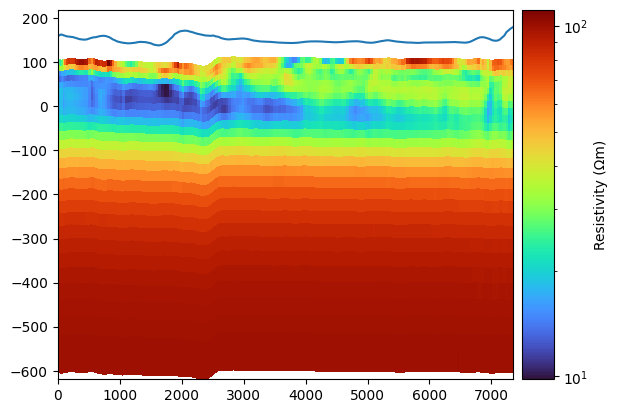

In [14]:
inv.l2.plot()

## Misfit

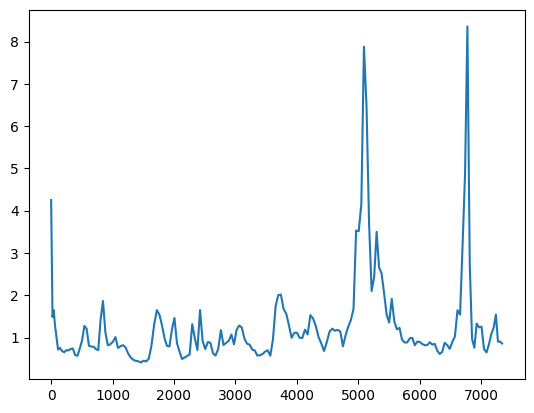

In [15]:
plt.plot(inv.l2pred.flightlines.xdist, inv.l2pred.flightlines.resdata)

In [16]:
inv.l2.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.model.xyz")
inv.l2pred.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.synthetic.xyz")

In [17]:
inv.l2.to_vtk("data/IncisedValley/aem_processed_data_foothill_central_valley.model.vtk")

resistivity_variance_factor  is not in the given dataframe. this attribute will not be written to the VTK.
line_id  is not in the given dataframe. this attribute will not be written to the VTK.
tx_alt  is not in the given dataframe. this attribute will not be written to the VTK.
invalt  is not in the given dataframe. this attribute will not be written to the VTK.
invaltstd  is not in the given dataframe. this attribute will not be written to the VTK.
deltaalt  is not in the given dataframe. this attribute will not be written to the VTK.
numdata  is not in the given dataframe. this attribute will not be written to the VTK.
resdata  is not in the given dataframe. this attribute will not be written to the VTK.
restotal  is not in the given dataframe. this attribute will not be written to the VTK.
doi_upper  is not in the given dataframe. this attribute will not be written to the VTK.
doi_lower  is not in the given dataframe. this attribute will not be written to the VTK.


# Comparing the synthetic data

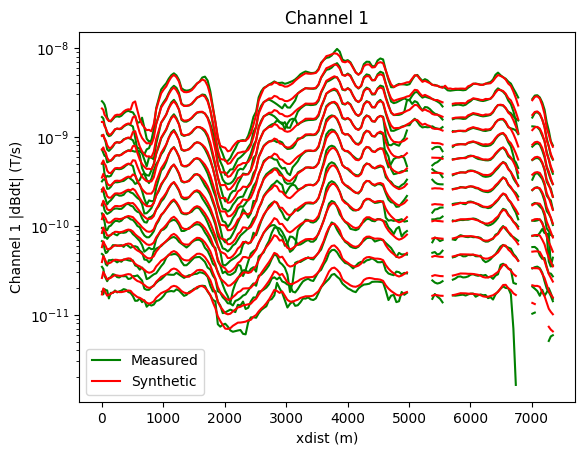

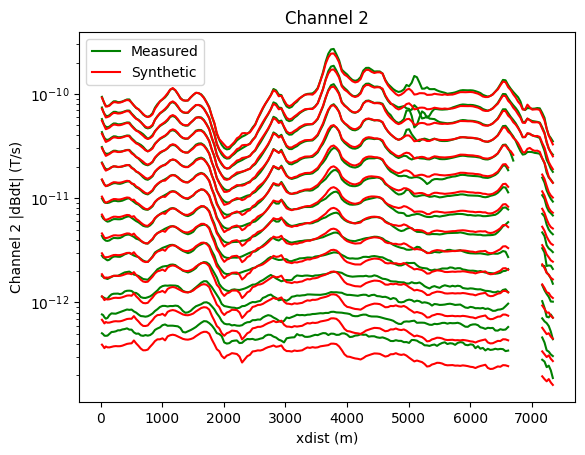

In [18]:
for channel in (1, 2):
    inv.xyz.plot_line(302701.0, channel=channel, ax=plt.gca(), color="green", label="Measured")
    inv.l2pred.plot_line(302701.0, channel=channel, ax=plt.gca(), color="red", label="Synthetic")
    plt.legend()
    plt.title("Channel %s" % channel)
    plt.show()


# Stand alone forward modelling
Forward modelling can be performed using the same system description as for inversions.
A model and a set of gate times are needed as input. Here we use the l2 model from the above inversion,
and the same gate times as in the original data

In [19]:
fwd = CalibratedSystem(
    inv.l2,
    times_full=inv.times_full,
    gate_filter__start_lm=7,
    gate_filter__end_lm=21,
    gate_filter__start_hm=15,
    gate_filter__end_hm=30,    
)
l2data = fwd.forward()

Using default (spLU) solver


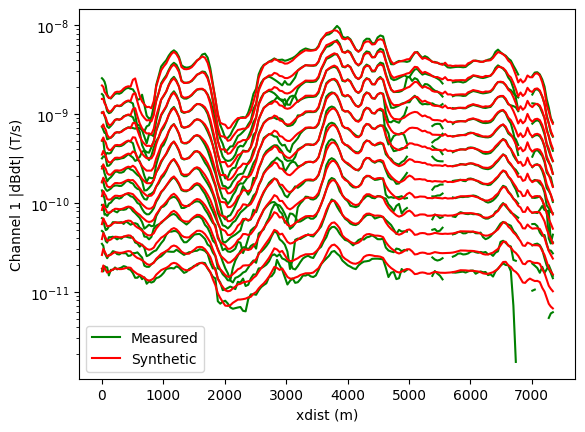

In [20]:
inv.xyz.plot_line(302701.0, ax=plt.gca(), color="green", label="Measured")
l2data.plot_line(302701.0, ax=plt.gca(), color="red", label="Synthetic")
plt.legend()
plt.show()